In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-05-17 18:05:48.814468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-17 18:05:48.858566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-05-17 18:05:48.858588: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-05-17 18:05:48.859036: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [4]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        plt.plot(denormed_time, denormed_label)
        plt.plot(denormed_time, denormed_pred)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

In [5]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 350
	Test count : 61

After Slicing: 
	Train count: 350
	Test count : 61


## Importing Model

In [6]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history = LoadModel(model_dir)

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("model_history keys: {}".format(model_history.keys()))

Found 19 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   ANN 2022-04-06 06:23:17
  [1].   ANN 2022-04-06 06:35:28
  [2].   ANN 2022-04-13 11:00:28
  [3].   ANN 2022-04-13 11:16:18
  [4].   ANN 2022-04-13 11:49:24
  [5].   ANN 2022-04-13 13:40:18
  [6].   ANN 2022-04-14 12:43:56
  [7].   ANN 2022-04-14 13:42:13
  [8].   ANN 2022-05-11 07:31:41
  [9].   ANN 2022-05-11 07:33:55
  [10].  ANN 2022-05-17 04:00:54
  [11].  ANN 2022-05-17 04:10:15
  [12].  ANN 2022-05-17 04:20:35
  [13].  ANN 2022-05-17 04:31:14
  [14].  ANN 2022-05-17 04:38:41
  [15].  ANN 2022-05-17 04:46:29
  [16].  ANN 2022-05-17 04:54:15
  [17].  ANN 2022-05-17 05:03:24
  [18].  ANN 2022-05-17 18:04:37
You selected model ANN 2022-05-17 18:04:37

model loaded
model history loaded
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])


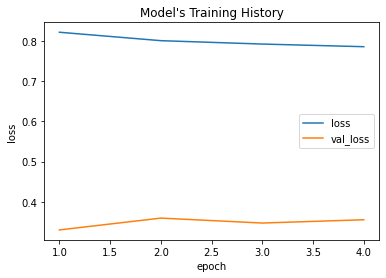

In [7]:
metric = 'loss'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

In [8]:
_z, _s = NORM_PARAM['elv_l_rad']
last_val_MAE = model_history['val_mean_absolute_error'][-1]

print ("denormed MAE: {}".format(denorm(last_val_MAE, _z, _s)))
print ("denormed MAE: {}".format(denorm(0.0000, _z, _s)))

elv_MAE = denorm(last_val_MAE, _z, _s)-denorm(0.0000, _z, _s)
elv_MAE = elv_MAE*180/math.pi 
print ("MAE: {} deg".format(elv_MAE))


denormed MAE: -0.06001428283024537
denormed MAE: -0.07888892859076359
MAE: 1.081437541882186 deg


## Making Few Predictions

In [9]:
filename = test_list[0]
os.path.basename(filename)

'flight_40943.csv'

2022-05-17 18:06:14.732220: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


timespan: 208.0
mae: 0.5136047005653381


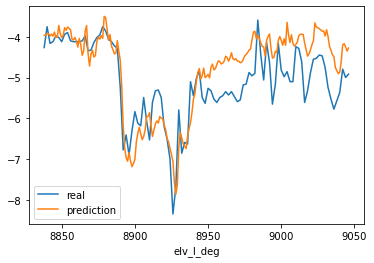

In [10]:
ShowPrediction( 
            "flight_10916.csv",
            model=model,
            window=pred_window
        )

## R2 Results

In [11]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,elv_l_rad
count,61.000000
mean,-5.077633
std,16.184172
min,-96.375212
25%,-2.957770
50%,-0.303807
75%,0.511327
max,0.821640


In [12]:
r2_df.nlargest(8, columns=labels)

,filename,elv_l_rad
57,flight_34487.csv,0.821640
6,flight_32957.csv,0.817128
29,flight_12357.csv,0.779712
32,flight_30570.csv,0.757675
35,flight_13990.csv,0.726741
23,flight_17411.csv,0.682326
16,flight_13493.csv,0.632051
41,flight_39464.csv,0.598913


In [13]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=labels)

,filename,elv_l_rad
58,flight_36060.csv,-96.375212
59,flight_35905.csv,-69.034564
1,flight_24828.csv,-38.474481
0,flight_40943.csv,-34.533691
8,flight_40699.csv,-15.101845
14,flight_40949.csv,-9.422068
19,flight_11823.csv,-7.431721
54,flight_17181.csv,-7.249905
56,flight_19184.csv,-4.369074
50,flight_37094.csv,-4.293640


filename: flight_40949.csv
timespan: 335.0
mae: 1.9494774341583252


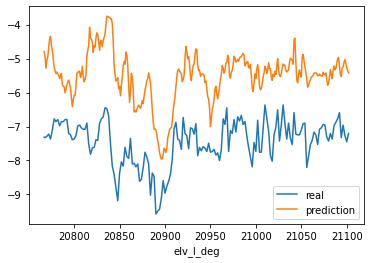

In [14]:
filename_to_predict = "flight_40949.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model, window=pred_window)

min: 199.0
max: 424.0
avg: 315.11475409836066


(array([1., 2., 0., 5., 1., 4., 4., 0., 2., 1., 1., 2., 1., 2., 0., 1., 2.,
        2., 4., 4., 4., 1., 4., 2., 2., 2., 1., 2., 2., 2.]),
 array([199. , 206.5, 214. , 221.5, 229. , 236.5, 244. , 251.5, 259. ,
        266.5, 274. , 281.5, 289. , 296.5, 304. , 311.5, 319. , 326.5,
        334. , 341.5, 349. , 356.5, 364. , 371.5, 379. , 386.5, 394. ,
        401.5, 409. , 416.5, 424. ]),
 <BarContainer object of 30 artists>)

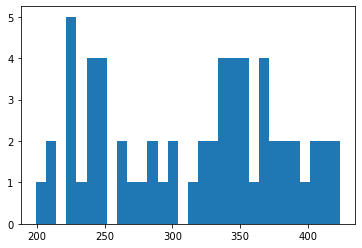

In [15]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [16]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

1

### Make Predictions

In [17]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_pred)
                ax.plot (denormed_time, denormed_label)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

/tmp/ipykernel_1919/2101324599.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


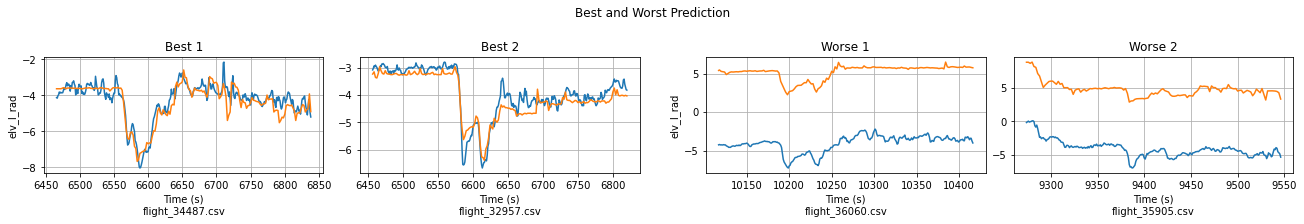

In [18]:
best_list = list(r2_df.nlargest(10, columns=labels).iloc[:2, 0])
worst_list = list(r2_df.nsmallest(10, columns=labels).iloc[:2, 0])
flight_list = best_list + worst_list

important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

fig = plt.figure(constrained_layout=True)

rows = len(G_PARAMS.SEQUENTIAL_LABELS)
cols = 4

gs = fig.add_gridspec(rows, cols)

for j in range(cols):
    big_title = important_title[j]
    flightname = flight_list[j]
    denormed_time, prediction_dict = Predict(
                                        filename=flightname,
                                        model=model,
                                        window=pred_window,
                                        NORM_PARAM=NORM_PARAM
                                    )
    
    for i in range(rows):
        label_index = i % rows
        label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

        denormed_label, denormed_pred = prediction_dict[label]

        ax = fig.add_subplot(gs[i, j])
        ax.plot (denormed_time, denormed_pred)
        ax.plot (denormed_time, denormed_label)
        ax.grid()

        if label_index == 0:
            ax.set_title(big_title)
        if label_index == rows-1:
            ax.set_xlabel("Time (s)" + "\n" + flightname)

        if j == 0 or j == 2:
            ax.set_ylabel('\n'*j + label)

fig.set_size_inches(18/4*cols, 3*rows)
fig.suptitle("Best and Worst Prediction\n")
fig.show()

/tmp/ipykernel_1919/18902602.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


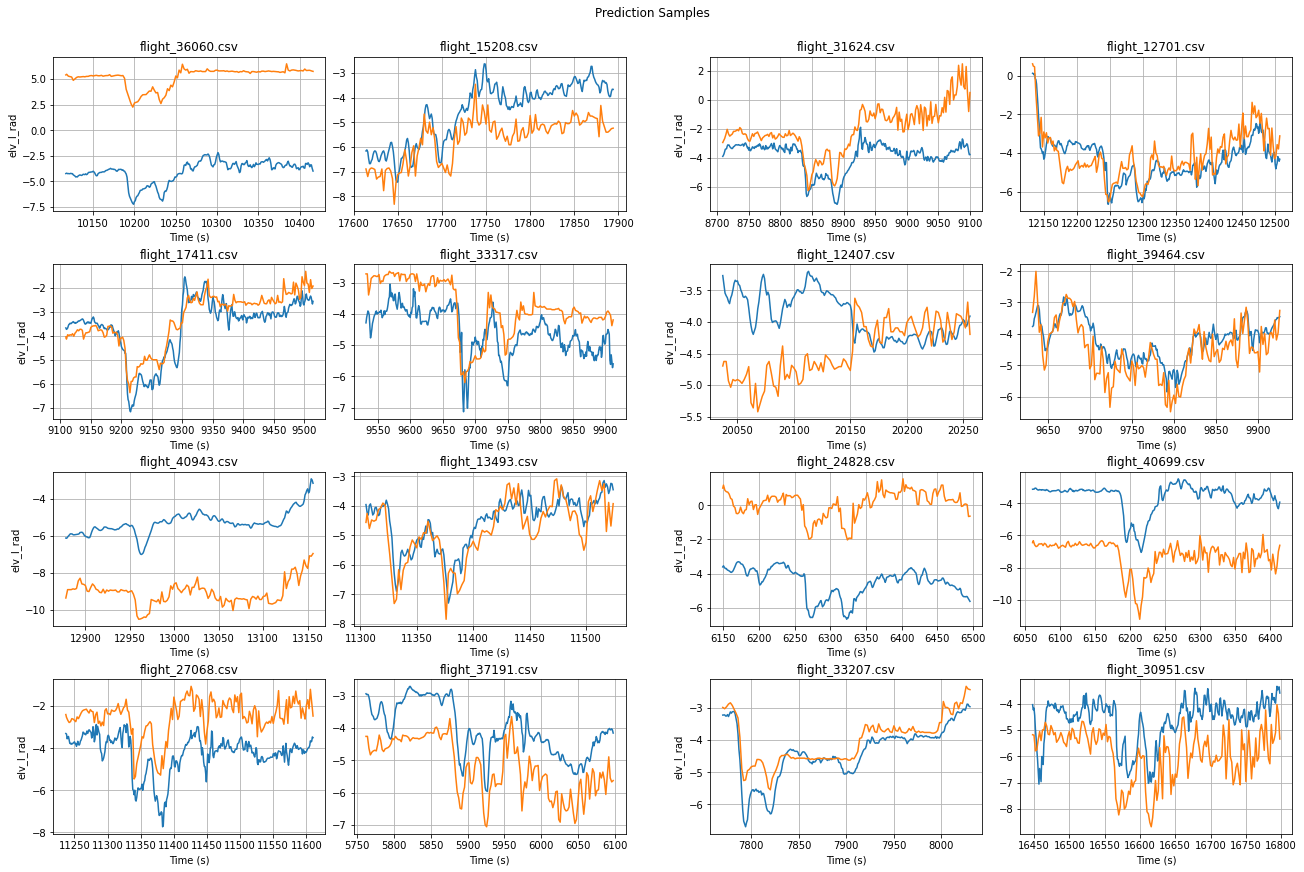

In [19]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)